load lib and set path, jupyter setting

In [1]:
import pandas as pd
DF = pd.DataFrame

import numpy as np
Series = pd.Series

import sys 
import os
os.chdir("""C:\\Users\\demetoir_desktop\\PycharmProjects\\MLtools""")

import missingno

import warnings
warnings.filterwarnings(module='seaborn*', action='ignore',category=RuntimeWarning)
warnings.filterwarnings(module='numpy*', action='ignore',category=RuntimeWarning)

# os.getcwd()
from tabulate import tabulate

import matplotlib.pyplot as plt
from script.util.PlotTools import PlotTools
plot = PlotTools(show=True, save=False, dpi=600)

from script.util.misc_util import *
from script.data_handler.Base.df_plotterMixIn import DF_PlotTools
from script.data_handler.DatasetPackLoader import DatasetPackLoader
from script.data_handler.titanic import load_merge_set, titanic_null_cleaner, titanic_typecasting, titanic_transformer
from script.sklearn_like_toolkit.ClassifierPack import ClassifierPack

NpArr = np.array
DF = pd.DataFrame
df_Xs_keys = [
    'col_00_Age', 'col_01_Cabin', 'col_02_Embarked', 'col_03_Fare',
    'col_04_Name', 'col_05_Parch', 'col_06_PassengerId', 'col_07_Pclass',
    'col_08_Sex', 'col_09_SibSp', 'col_11_Ticket'
]

df_Ys_key = 'col_10_Survived'

merge_df = load_merge_set(cache=False)
origin_df = merge_df
cleaner = titanic_null_cleaner(merge_df.copy(), df_Xs_keys, df_Ys_key)
cleaned_df = cleaner.clean()

typecaster = titanic_typecasting(cleaned_df, df_Xs_keys, df_Ys_key)
type_casted_df = typecaster.type_cast()

transformer = titanic_transformer(type_casted_df, df_Xs_keys, df_Ys_key)
transformer_df = transformer.transform()


# merge_df.info()
# transformer_df.info()

# autocomplete setting 
%config IPCompleter.greedy=True

# print every line of code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

dataset_pack = DatasetPackLoader().load_dataset('titanic', cache=False)
train_set = dataset_pack['train']
test_set = dataset_pack['test']

df = train_set.to_DataFrame()
transform_train_df = df.drop(['Xs', 'Ys', 'id_'], axis=1)

df = test_set.to_DataFrame()
transform_test_df = df.drop(['Xs', 'id_'], axis=1)

load titanic dataset module


# 1. Intro


제임스 카메론이 감독한 영화 타이타닉은 최초의 10억돌파 영화이자 1990년대를 대표하는 명작 블록버스터이다. 이 영화는 잭 도슨(레오나르도 디카프리오)와 로즈 드윗 뷰케이터(케이트 윈즐렛)의 비극적인 사랑과 타이타닉호 침몰사건의 정밀한 고정과 재연을 한 다큐멘터리의 극적인 조합으로 20년이 지난 지금도 꾸준히 화자되는 영화이다. 

영화에서는 당시 침몰 사건 당시의 승객들의 여러 모습을 자세하게 묘사한다. 사랑하는 자신의 아이를 구명보트에 태우기 위해 희생하는 아버지와 어머니, 살기위해 강제로 구명선에 타려고 난동을 부리는 사람, 구명보트에 타는것을 포기한 사람들등 수많은 인간군상을 볼 수 있다.


이제 우리가 풀어야 할 문제를 정의 해보자.
우리는 타이타닉 호가 침몰할 당시, 어떠한 요인들이 생존에 영향을 미쳤는지 분석하고자 한다.
또한 이 분석들을 토대로 생존과 사망을 예측하는 Binary Classification 모델을 만들고자 한다.

# 2. Skim over dataset 

Kaggle에서 제공하는 titanic dataset은 타이타닉의 승객들의 정보를 바탕으로 만들어진 dataset으로 총 instance 수는 1309개, 피쳐수는 10개(passenger) 이다.
train set과 test set로 나누어져있고, 각각 891, 418개의 instance로 구성되어있다. train set에서만 승객의 생존 여부가 존재하고, 제출을 위하여 test set에는 생존여부가 존재 하지 않는다.

feature의 정보는 다음과 같다.

표로 정리
Survived: 생존 여부
Pclass: 승객 클래스(1,2,3등석)	Ticket class	
Sex	성별
Age	나이 
Sibsp	승객 중 형제 수 / 배우자 수
Parch   승객 중 부모 수 / 자녀 수
Ticket	티겟 넘버	
Fare	승선비
Cabin	선박번호
Embarked	탑승지 (C = Cherbourg, Q = Queenstown, S = Southampton)




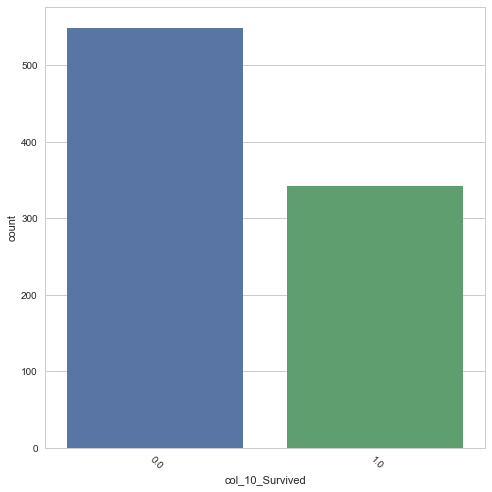

In [2]:
plot.count(merge_df, df_Ys_key, title='')

train set 에서 전체 승객의 생존여부에 대한 비율을 보면,38%는 생존하였고, 62%는 사망하였다.
따라서 사망한 승객의 비율이 더 많으므로 단순히 모두 사망하였다고 하여도 62%의
정확도를 가지게 된다.
그러니 이제는 이런 단순한 모델보다 더 정확도가 높은 모델을 만들기 위해 전체 데이터를 보자


# 3. Cleaning missing value

가장 먼저 할일은 전체 데이터셋에 대하여 missing value가 존재 하는지 확인하는것이다.

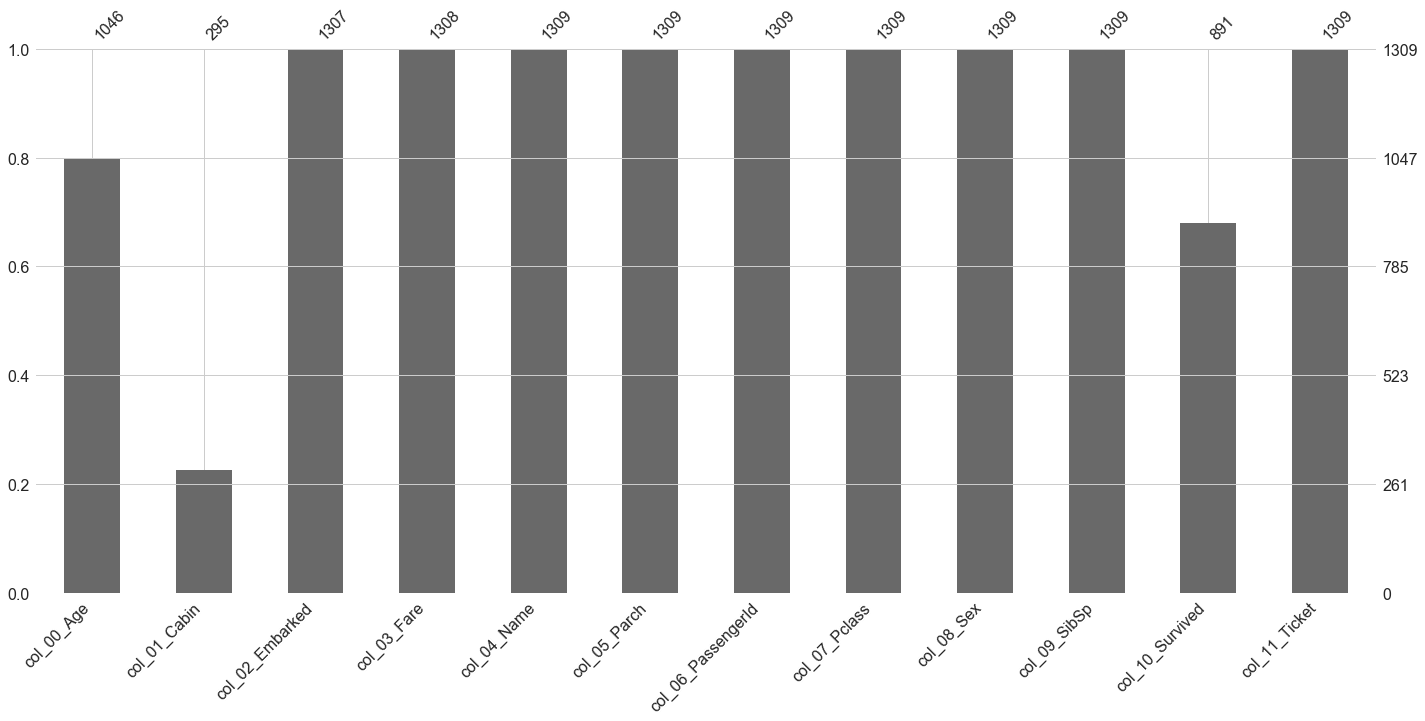

In [32]:
column = origin_df.columns
column = ['col_00_Age', 'col_01_Cabin', 'col_02_Embarked', 'col_03_Fare',
       'col_04_Name', 'col_05_Parch', 'col_06_PassengerId', 'col_07_Pclass',
       'col_08_Sex', 'col_09_SibSp', 'col_10_Survived', 'col_11_Ticket',
       ]
missingno.bar(origin_df[column])
plt.show()

4개의 feature인 Embarked, Fare, Age, Cabin가 missing value를 가지고있다. 
Embarked feature 와 Fare feature는 각각 1~2개정도의 missing value이므로 각각의 데이터의 최빈값으로 치환하여도 무방하다.


Age feature의경우 20% 가 missing value이므로, 먼저 missing value가 아닌 값만 가지고 생존 여부를 별로 Age의 분포를 확인하자.

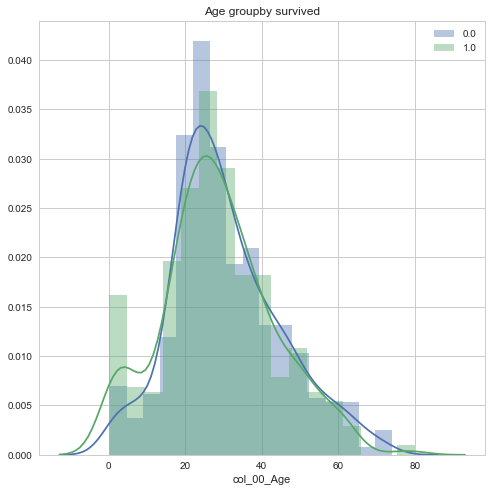

In [4]:
age_df = DF(merge_df[['col_00_Age']])
age_s = age_df['col_00_Age']
col = 'col_00_Age'
age_df_notna = merge_df[merge_df['col_00_Age'].notna()]
plot.dist_groupby(age_df_notna, 'col_00_Age', 'col_10_Survived', title='Age groupby survived')

18세 미만의 승객들의 생존율이 높음을 알 수 있고 20대 승객의 생존율이 낮음을 알 수 있다. 그외의 범위에서는 생존율의 차이가 별로 없다. 이 경우 남자와 여자일때가 합처져있으므로 각각 남여 나이별 생존율을 알아보자.

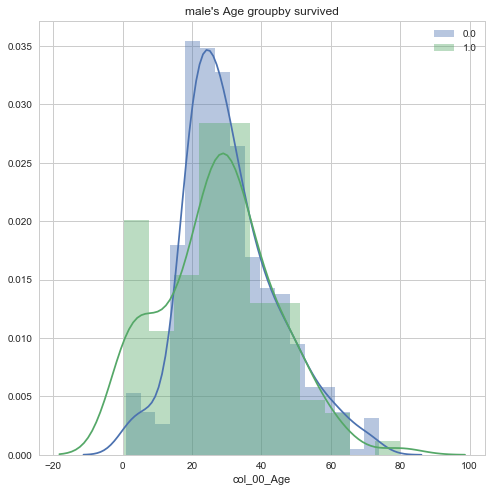

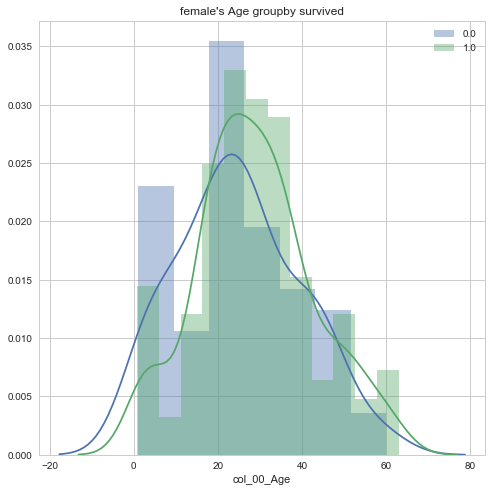

In [5]:
age_df = DF(merge_df[['col_00_Age']])
age_s = age_df['col_00_Age']
col = 'col_00_Age'
age_df_notna = merge_df[merge_df['col_00_Age'].notna()]

male = age_df_notna[age_df_notna['col_08_Sex'] == 'male']
plot.dist_groupby(male, 'col_00_Age', 'col_10_Survived', title="male's Age groupby survived")

female = age_df_notna [age_df_notna['col_08_Sex'] == 'female']
plot.dist_groupby(female, 'col_00_Age', 'col_10_Survived', title="female's Age groupby survived")

특이 한것은 18세미만의 남자의 생존율은 높은 반면, 18세미만의 여자의 경우는 생존율이 낮다는 점이다. missing value가 아닌값은 나이에 따라 이제 적절히 binning(bucketization)을 하고, 나머지 missing valued인 경우 'bin8_missing'로 binning 해주자.


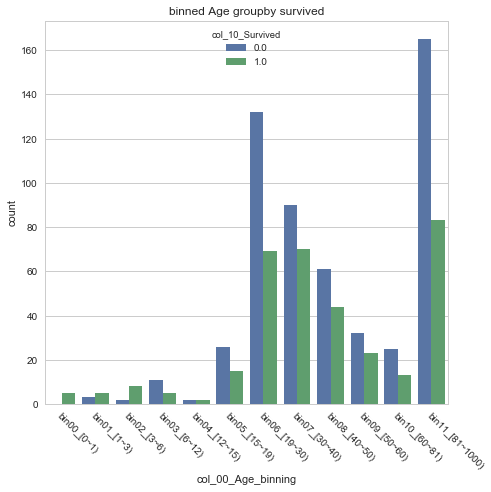

In [6]:
plot.count(transformer_df, 'col_00_Age_binning', df_Ys_key, title='binned Age groupby survived')

다음은 Cabin feature 이다. Cabin은 78%가량이 missing value 이므로 feature를 drop시키는 방법도 있지만 먼저 데이터를 살펴보자.




a = """
표로 보여주기
col_01_Cabin

A36
B57 B59 B63 B66
C62 C64
C65
D
D10 D12
F G63
F G73
G6
T
"""

missing value가 아닌 값들은 보면 알파벳과 숫자가 합쳐진 형태이고, 일부는 숫자가 없거나,  
여러개의 C23 C25 C27 값을 가지는것을 볼수있다. 여기서 눈여겨 봐야 할 것은 알파벳이 배의 갑판을 의미한다는 것이다. 따라서 갑판마다 승객의 생존율이 차이가 날 수 있으므로 갑판 별 승객 생존율을 구해보았다.

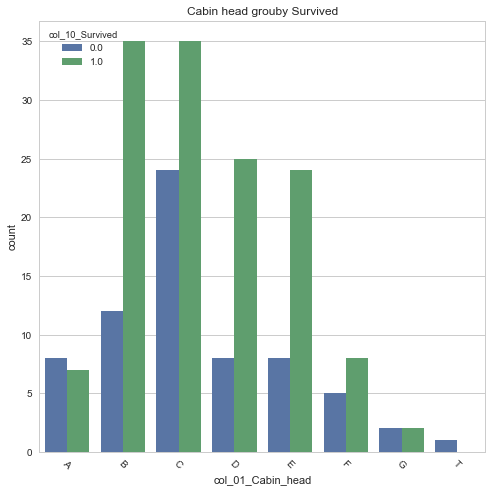

In [7]:
col = 'col_01_Cabin'
df_Ys_key = 'col_10_Survived'

Embarked_df = DF(merge_df[[col]])
Embarked_s = Embarked_df[col]
partial =  transformer_df[transformer_df['col_01_Cabin_head'] != 'none']
plot.count(partial, 'col_01_Cabin_head', groupby_col=df_Ys_key, title='Cabin head grouby Survived')

B,D,E  갑판의 승객인 경우 확연히 높은 생존율을 보였고, 
T를 제외한 A,C,F,G 갑판의 승객인 경우 또한 50%이상의 생존율을 보여줬다.
전체 승객의 평균적인 생존율이 38%가량 되는것을 생각해보면 cabin이 유의미한 feature라고 판단할 수 있다. 따라서, Cabin_head 라는 이름으로 새로운 feature 추가하였다.

Age와 비슷한 방식으로 missing value는 'none'으로 대체 하였다.

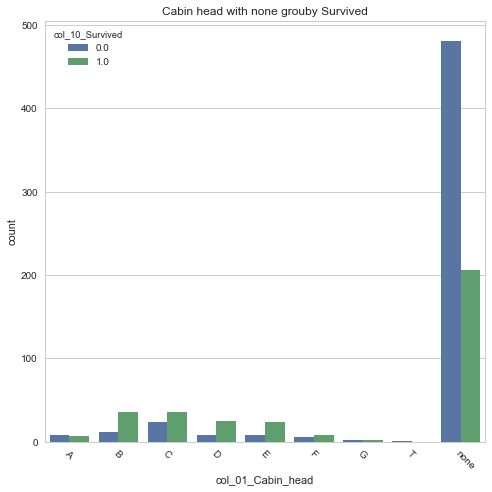

In [8]:
plot.count(transformer_df, 'col_01_Cabin_head', groupby_col=df_Ys_key, title='Cabin head with none grouby Survived') 

missing value에서는 생존율이 지극히 적음을 확인할 수 있었다.

# 4. Checking correlation

이제 missing value에 대하여 처리 하였으니 각 피처와 생존여부에 대한 상관도를 구하여 feature 중요도를 살펴보자. 

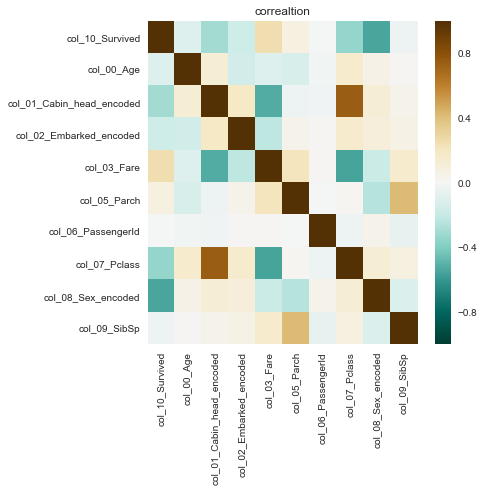

In [9]:
cols = [
    'col_10_Survived',
    'col_00_Age', 
       'col_01_Cabin_head_encoded',
       'col_02_Embarked_encoded', 
        'col_03_Fare',
     'col_05_Parch',
       'col_06_PassengerId', 
 'col_07_Pclass',
       'col_08_Sex_encoded',
 'col_09_SibSp',
]

corr = transform_train_df[cols].corr()
plot.heatmap(corr, title='correaltion')

생존여부와 다른 피처사이의 상관도를 절대값을 취하여 비교해보자

In [10]:
cols = [
    'col_10_Survived',
    'col_00_Age', 
       'col_01_Cabin_head_encoded',
       'col_02_Embarked_encoded', 
        'col_03_Fare',
       'col_03_Fare_binning', 
        'col_04_Name',
     'col_05_Parch',
       'col_06_PassengerId', 
 'col_07_Pclass',
       'col_08_Sex_encoded',
 'col_09_SibSp',
       'col_11_Ticket',
    'col_11_Ticket_head', 
    'col_11_Ticket_num',
]

corr = transform_train_df[cols].corr()

corr_df = DF(corr[df_Ys_key].sort_values())
corr_df.columns =[ 'correlation_with_survived' ]
corr_df[ 'absolute_correlation_with_survived'] = np.abs(corr_df[ 'correlation_with_survived' ])
corr_df.sort_values(by='absolute_correlation_with_survived', ascending=False)

,correlation_with_survived,absolute_correlation_with_survived
col_10_Survived,1.000000,1.000000
col_08_Sex_encoded,-0.543351,0.543351
col_07_Pclass,-0.338481,0.338481
col_01_Cabin_head_encoded,-0.301116,0.301116
col_03_Fare,0.257307,0.257307
col_02_Embarked_encoded,-0.167675,0.167675
col_00_Age,-0.094489,0.094489
col_05_Parch,0.081629,0.081629
col_09_SibSp,-0.035322,0.035322
col_06_PassengerId,-0.005007,0.005007


Sex가 가장 높은 상관도를 가지는것을 확인할수있다.

PassengerId는 가장 낮은 상관도를 보여줬는데, 이는 유니크한 값 만을 가지므로 
모델의 학습에는 적절하지 않다는 것을 나타낸다. 그리고 feature engineering을 통해 얻은 Cabin_head feature는 Fare보다 더 높은 상관도를 가지는것이 눈여겨 볼만하다.

# 5. Feature engineering

이제는 앞서 살펴본 correlation matrix를 바탕으로 낮은 연관도를 가지는 feature을 가지고 feature enginearing을 해보자.

## 5.1  Family_size

sibsp와 parch이 각각 가족과 관련된 feature로, sibsp + parch + 1 을 해주면 해당 승객의
가족수를 구할 수 있다. 한번 family_size라는 새로운 feature를 만들어서 생존율을 비교해보자

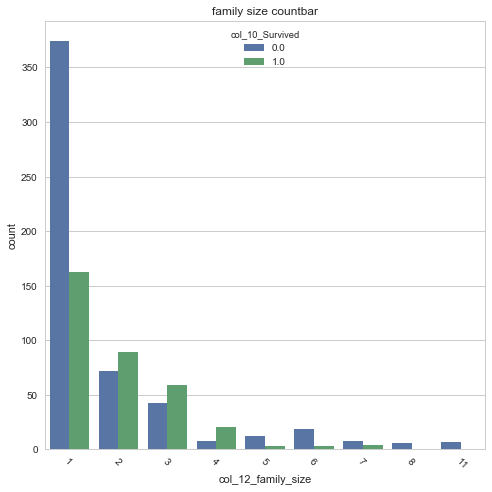

In [11]:
col = 'col_12_family_size'
# df = DF(merge_df)
# df[col] = df['col_05_Parch'] + df['col_09_SibSp'] + 1
plot.count(transformer_df, col, df_Ys_key, title='family size countbar')

family_size의 생존율을 비교해보면 2~4인 가족의 생존율이 상대적으로 높은반면 
1인 또는 5인 이상의 가족수의 경우 생존율이 떨어짐을 알 수 있다.
1인, 2~4인, 5인 가족일경우로 나누어 binning(bucketization)을 적용하였다

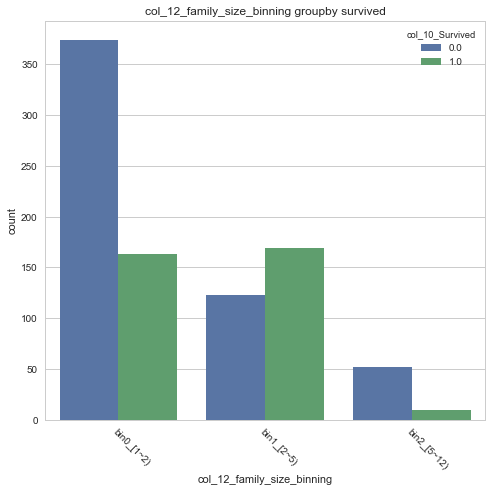

In [12]:
plot.count(transformer_df, 'col_12_family_size_binning', df_Ys_key, title='col_12_family_size_binning groupby survived')

# 5.2 Name_Honorific

이름을 살펴보면 "성, 존칭. 이름" 으로 이루어져있다.
존칭만 따로 따로 추출했을때의 feature를 Name_Honorific로 할 수 있다
한번 각 Honorific별로 생존율을 확인해보자.

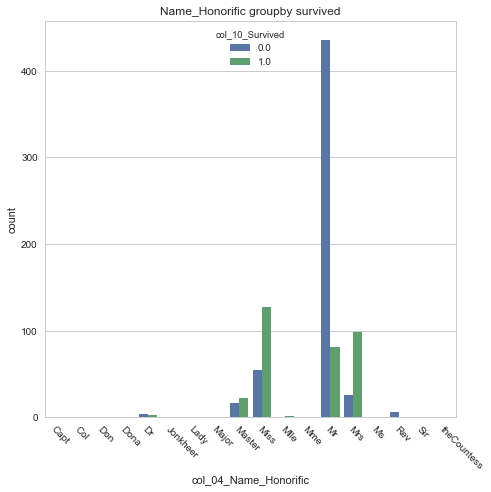

In [13]:
col = 'col_04_Name'
Honorific_col = 'col_04_Name_Honorific'
plot.count(transformer_df,Honorific_col, df_Ys_key, title='Name_Honorific groupby survived')

대부분의 값은 'Mr', 'Mrs', 'Miss', 'Master' 와  나머지 희귀한 존칭들로 이루어져있다.
'master'의 경우 보통 젊은 상속자에게 많이 붙이는 존칭으로 대부분 어린 남자들로 이루어져있다.
'Mrs'와 'Miss'는 각각 기혼 여성, 미혼 여성인데, 기혼 여성의 경우 생존율이 더 높은것을 알 수 있다.
희귀한 존칭의 경우('Don', 'Rev' 등..) 수가 너무 적기떄문에 'rare' 로 묶어버렸다

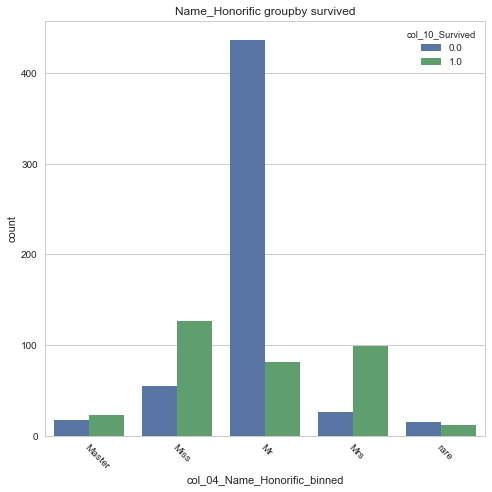

In [14]:
# transformer_df.info()
plot.count(transformer_df,'col_04_Name_Honorific_binned', df_Ys_key, title='Name_Honorific groupby survived')

## 5.3 Fare


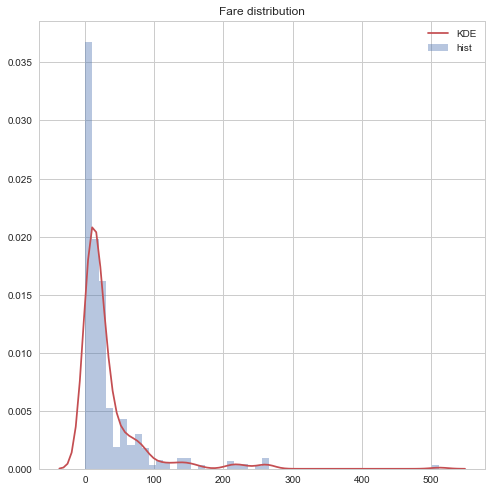

In [15]:
col = 'col_03_Fare'
df_Ys_key = 'col_10_Survived'
plot.dist(transformer_df, col, title='Fare distribution')

Fare의 분포를 살펴보면, 대부분의 값은 전체의 90%가  0~100 사이에 존재하는 매우 편형된 분포임을 알 수 있다.
생존자 및 사망자의 Fare분포를 확인해보자.

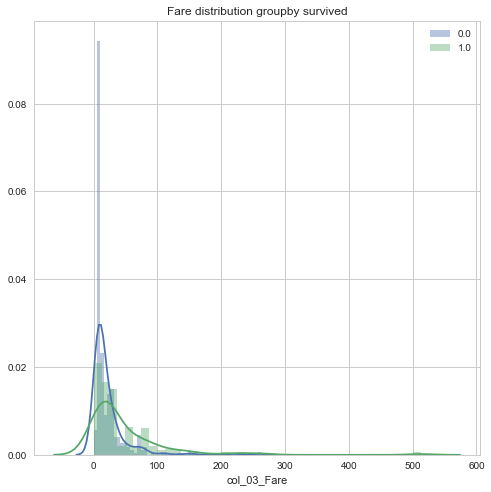

In [16]:
plot.dist_groupby(transformer_df, col, df_Ys_key, title='Fare distribution groupby survived')

Fare 값이 큰 값을 가질수록 생존율이 더 높음을 알 수 있다.

binning(bucketization)을 적용하여 좀더 해석하기 쉽게 변경하였다.

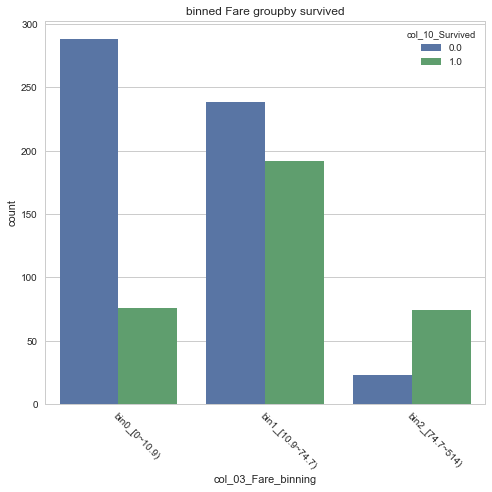

In [17]:
plot.count(transformer_df, 'col_03_Fare_binning', df_Ys_key, title='binned Fare groupby survived')

##  5.5 with_only_family

일행은 티켓의 번호가 같다고 가정할 때,
그 일행이 같은 성으로만 이루어진 가족인 경우 1의 값을 가지고,
일행에 다른 성을 가진 사람이 포함된 가족인 경우 0의 값을 가지도록 with_only_family 피처를 만들고 
이때 생존율의 차이를 비교해보았다.

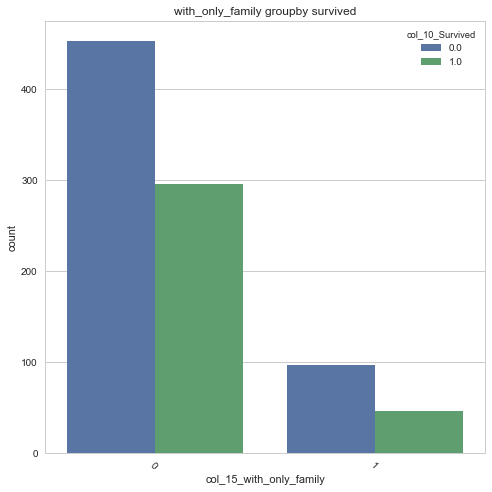

In [18]:
col = 'col_15_with_only_family'
plot.count(transformer_df, col, df_Ys_key, title='with_only_family groupby survived')

일행에 가족만있는경우가 좀더 높은 생존율을 보인다


# 5.6 Rechecking feature

feature engineering은 이정도로 마치고 feature engineering을 통해 새롭게 만들어지거나 변형된 feature가 존재하니 다시 상관도를 분석해보자.

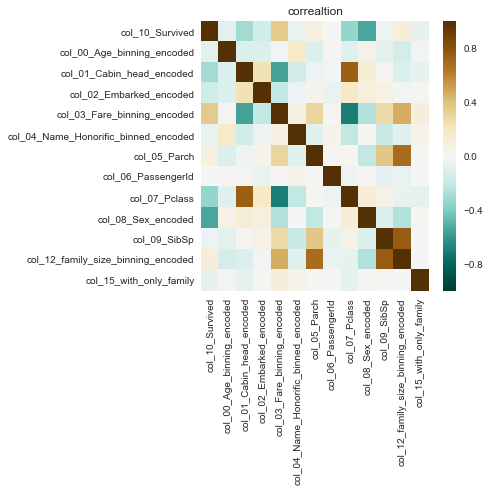

In [19]:
merge_df = load_merge_set(cache=False)
origin_df = merge_df
cleaner = titanic_null_cleaner(merge_df.copy(), df_Xs_keys, df_Ys_key)
cleaned_df = cleaner.clean()

typecaster = titanic_typecasting(cleaned_df, df_Xs_keys, df_Ys_key)
type_casted_df = typecaster.type_cast()

transformer = titanic_transformer(type_casted_df, df_Xs_keys, df_Ys_key)
transformer_df = transformer.transform()



cols = [
    'col_10_Survived',
    'col_00_Age_binning_encoded', 
       'col_01_Cabin_head_encoded',
       'col_02_Embarked_encoded', 
    'col_03_Fare_binning_encoded', 

        'col_04_Name_Honorific_binned_encoded',

     'col_05_Parch',
       'col_06_PassengerId', 
 'col_07_Pclass',

       'col_08_Sex_encoded',
 'col_09_SibSp',
       'col_12_family_size_binning_encoded',

'col_15_with_only_family'
]



corr = transformer_df[cols].corr()
# corr
plot.heatmap(corr, title='correaltion')




In [26]:
cols = [
    'col_10_Survived',
    'col_00_Age', 
    'col_00_Age_binning_encoded', 
       'col_01_Cabin_head_encoded',
       'col_02_Embarked_encoded', 
        'col_03_Fare',
      'col_03_Fare_binning_encoded', 
        'col_04_Name_Honorific_binned_encoded',
     'col_05_Parch',
       'col_06_PassengerId', 
 'col_07_Pclass',
       'col_08_Sex_encoded',
 'col_09_SibSp',
    'col_12_family_size',
       'col_12_family_size_binning_encoded',
'col_15_with_only_family'
]

# corr = transform_train_df[cols].corr()
corr = transformer_df[cols].corr()

corr_df = DF(corr[df_Ys_key].sort_values())
corr_df.columns =[ 'correlation_with_survived' ]
corr_df[ 'absolute_correlation_with_survived'] = np.abs(corr_df[ 'correlation_with_survived' ])
corr_df.sort_values(by='absolute_correlation_with_survived', ascending=False)


,correlation_with_survived,absolute_correlation_with_survived
col_10_Survived,1.000000,1.000000
col_08_Sex_encoded,-0.543351,0.543351
col_03_Fare_binning_encoded,0.354637,0.354637
col_07_Pclass,-0.338481,0.338481
col_01_Cabin_head_encoded,-0.301116,0.301116
col_03_Fare,0.257307,0.257307
col_02_Embarked_encoded,-0.167675,0.167675
col_12_family_size_binning_encoded,0.108631,0.108631
col_00_Age,-0.094489,0.094489
col_00_Age_binning_encoded,-0.082485,0.082485


새로 만들어진 feature인 family_size는 그대로일때보다 binning을 했을때 더 높은 상관도를 가지는것을 알 수 있다.
또한 with_only_family의 경우, 상관도가 Name_Honorific을 binning 했을때와 비슷한 상관도를 보임을 알 수 있다.

# 6. Visualization by Dimensionality Reduction

Dimensionality Reduction는 고차원의 데이터를 저차원의 데이터로 매핑하는 기술로 데이터를 시각화하거나 전처리 하는데 사용한다. 여기서는 데이터를 시각화 하는 목적으로 사용하겠다.

우리가 사용할 알고리즘은 PCA(Principal component analysis)와 Autoencoder이다PCA의 경우 scikit-learn 라이브러리 구현체를 사용하였고, Autoencoder의 경우 Tensorflow 로 직접 구현한것을 사용하였다.

다음은 PCA와 Autoencoder를 각각 사용하여 2차원으로 압축시켰을때의 모습이다.

생존자와 사망자의 분포를 살펴보면 일정부분은 생존자와 사망자가 비슷한 위치에 존재함을 알 수 있다. 이는 생존자와 사망자의 feature의 차이가 거의 없는 경우가 존재함을 의미한다. 이는 모델이 training set에서 학습을 완벽히 하더라도 test set prediction을 했을 경우, test score의 상한선이 존재함을 알 수 있다.



![pca_valid](./pca/pca_test.png)
![pca_train](./pca/pca_train.png)


![ae_valid](./pca/ae_valid.png)
![ae_train](./pca/ae_train.png)



#  7. Modeling and evaluation

dataset을 shuffle한뒤, 7:3 비율로 training set 과 validation set으로 나누어 
training set 에서 모델을 training 후 각각의 set에서 score를 측정해 보았다.

scikit-learn, XGBoost, LightGBM, CatBosot 라이브러리의 모델을 사용하였다.


10회 반복했을때의 모델의 평균 정확도를 측정해보았다.

### train score

In [21]:
cols = [
        'model',
        'accuracy_mean',
        'accuracy_std',
        'accuracy_min',
        'accuracy_max',
        
#         'precision_score_max',
#         'precision_score_mean',
#         'precision_score_min',
#         'precision_score_std',
#         'recall_score_max',
#         'recall_score_mean',
#         'recall_score_min',
#         'recall_score_std',
#         'roc_auc_score_max',
#         'roc_auc_score_mean',
#         'roc_auc_score_min',
#         'roc_auc_score_std',
    ]

train_df = pd.read_csv('./out/clf_pack_train_score_pack.csv', index_col=False)
train_df = train_df[cols]
train_df.sort_values(by='accuracy_mean', ascending=False) 

,model,accuracy_mean,accuracy_std,accuracy_min,accuracy_max
5,skExtraTreesClf,0.896469,0.003815,0.890851,0.905297
3,skDecisionTreeClf,0.895506,0.005099,0.890851,0.906902
4,skRandomForestClf,0.895345,0.004173,0.889246,0.902087
12,skBaggingClf,0.893740,0.004963,0.887640,0.905297
11,skGaussianProcessClf,0.887159,0.006542,0.881220,0.903692
15,CatBoostClf,0.887159,0.005277,0.881220,0.897271
14,LightGBMClf,0.874960,0.004786,0.868379,0.884430
0,skMLPClf,0.873515,0.007278,0.865169,0.890851
7,skGradientBoostingClf,0.872552,0.005429,0.866774,0.886035
13,XGBoostClf,0.860674,0.007624,0.852327,0.876404


### validation score

In [22]:
cols = [
        'model',
        'accuracy_mean',
        'accuracy_std',
        'accuracy_min',
        'accuracy_max',
        
#         'precision_score_max',
#         'precision_score_mean',
#         'precision_score_min',
#         'precision_score_std',
#         'recall_score_max',
#         'recall_score_mean',
#         'recall_score_min',
#         'recall_score_std',
#         'roc_auc_score_max',
#         'roc_auc_score_mean',
#         'roc_auc_score_min',
#         'roc_auc_score_std',
    ]
valid_df = pd.read_csv('./out/clf_pack_valid_score_pack.csv',  index_col=False)
valid_df = valid_df[cols]
valid_df.sort_values(by='accuracy_mean', ascending=False)

,model,accuracy_mean,accuracy_std,accuracy_min,accuracy_max
12,skBaggingClf,0.900000,0.011537,0.873134,0.914179
5,skExtraTreesClf,0.897388,0.008869,0.876866,0.910448
3,skDecisionTreeClf,0.895896,0.011853,0.869403,0.906716
11,skGaussianProcessClf,0.889179,0.015207,0.850746,0.902985
4,skRandomForestClf,0.888806,0.009701,0.873134,0.902985
15,CatBoostClf,0.885448,0.012268,0.861940,0.899254
7,skGradientBoostingClf,0.878358,0.012621,0.847015,0.891791
14,LightGBMClf,0.876493,0.011125,0.854478,0.891791
0,skMLPClf,0.872388,0.016919,0.832090,0.891791
13,XGBoostClf,0.861194,0.017723,0.824627,0.880597


hyperparameter tuning 하기위해 HyperOpt 라이브러리의 tpe algorithm 을 사용하였고, 다음 이 아래의 결과이다.

### train score

In [23]:
cols = [
        'model',
        'accuracy_mean',
        'accuracy_std',
        'accuracy_min',
        'accuracy_max',
#         'precision_score_max',
#         'precision_score_mean',
#         'precision_score_min',
#         'precision_score_std',
#         'recall_score_max',
#         'recall_score_mean',
#         'recall_score_min',
#         'recall_score_std',
#         'roc_auc_score_max',
#         'roc_auc_score_mean',
#         'roc_auc_score_min',
#         'roc_auc_score_std',
    ]

train_df = pd.read_csv('./out/clf_pack_Hyperopt_train_score_pack.csv', index_col=False)
train_df = train_df[cols]
train_df.sort_values(by='accuracy_mean', ascending=False)

,model,accuracy_mean,accuracy_std,accuracy_min,accuracy_max
12,skBaggingClf,0.899197,0.007522,0.886035,0.910112
11,skGaussianProcessClf,0.888925,0.007488,0.873194,0.900482
14,CatBoostClf,0.888764,0.006998,0.878010,0.900482
7,skGradientBoostingClf,0.884109,0.006989,0.873194,0.897271
13,XGBoostClf,0.874318,0.009250,0.860353,0.890851
10,skRBF_SVMClf,0.872071,0.009025,0.853933,0.887640
3,skDecisionTreeClf,0.869021,0.007467,0.857143,0.882825
5,skExtraTreesClf,0.868379,0.009604,0.853933,0.886035
0,skMLPClf,0.856019,0.009870,0.836276,0.871589
4,skRandomForestClf,0.848315,0.008857,0.833066,0.865169


### validation score

In [24]:
valid_df = pd.read_csv('./out/clf_pack_Hyperopt_valid_score_pack.csv',  index_col=False)
valid_df = valid_df[cols]
valid_df.sort_values(by='accuracy_mean', ascending=False)

,model,accuracy_mean,accuracy_std,accuracy_min,accuracy_max
12,skBaggingClf,0.902239,0.017486,0.876866,0.932836
14,CatBoostClf,0.885448,0.016269,0.858209,0.910448
11,skGaussianProcessClf,0.885075,0.017406,0.858209,0.921642
7,skGradientBoostingClf,0.885075,0.016247,0.854478,0.910448
10,skRBF_SVMClf,0.872015,0.020979,0.835821,0.914179
5,skExtraTreesClf,0.865672,0.022326,0.824627,0.899254
13,XGBoostClf,0.863060,0.021503,0.824627,0.895522
3,skDecisionTreeClf,0.860448,0.017358,0.828358,0.888060
0,skMLPClf,0.845896,0.022944,0.809701,0.891791
4,skRandomForestClf,0.845149,0.020590,0.805970,0.880597


# 8. Evaluation 
Hyperparameter tuning 된 단일 모델과 ensemble을 적용한 모델들을 가지고 Kaggle에 submit 하였으며, 아래는 가장 점수가 높았을 때의 점수이다.

![kaggle_submit_score](./pca/kaggle_submit_score.png)

# 9. Disccussion

여러가지 feature들이 있었지만 생존 여부를 판가름 하는 유의미한 feature는 4가지 뿐이었으며, 
col_01_Cabin_head_encoded, col_03_Fare_binning_encoded, col_07_Pclass, col_08_Sex_encoded 가 있었다. 따라서, 이들 각각에 대한 특성을 보면 1등석 즉 요금이 비쌀 때 그리고 객실이 B,D,E이고 여성일 때 생존가능성이 가장 높다고 판단할 수 있다.
